# Analyze RNA tetramers (vanilla)

### TODO
- add inner minor ticks
- change xtick range to 0 - 360 for backbone torsion plot
- optimize definition to categorize structures

In [1]:
import os, sys, math
import numpy as np
import glob
import mdtraj
import logging
import netCDF4 as nc
import warnings
import pandas as pd
#from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import seaborn as sns

#import openmmtools as mmtools
#from pymbar import timeseries
#from openmm import *
#from openmm.app import *
#from openmm.unit import *

import barnaba as bb
from barnaba import definitions
from barnaba.nucleic import Nucleic

In [2]:
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")

In [3]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.precision = 1
pd.options.display.float_format = '{:.1f}'.format

In [4]:
#plt.rcParamsDefault

In [5]:
params = {'legend.fontsize': 40, 
          'font.size': 40, 
          'axes.labelsize': 48,
          'axes.titlesize': 48,
          'xtick.labelsize': 40,
          'ytick.labelsize': 40,
          'savefig.dpi': 600, 
          'figure.figsize': [64, 8],
          'xtick.major.size': 10,
          'xtick.minor.size': 7,
          'ytick.major.size': 10,
          'ytick.minor.size': 7}

plt.rcParams.update(params)

In [6]:
backbone_sugar_atoms = [
    "C1'", \
    "H1'", \
    "C2'", \
    "H2'", \
    "C3'", \
    "H3'", \
    "C4'", \
    "H4'", \
    "C5'", \
    "H5'", \
    "H5''", \
    "O2'", \
    "HO2'", \
    "O3'", \
    "O4'", \
    "O5'", \
    "P", \
    "OP1", \
    "OP2", \
    "HO5'", \
    "HO3'"
]

In [7]:
def radian_to_degree(a):
    """
    a : list
        [trajectory frame : residue : torsion]
    """
    
    a[np.where(a<0.0)] += 2.*np.pi
    a *= 180.0/np.pi

    # same as above
    #a = a*(180./np.pi)
    #a[np.where(a<0.0)] += 360
    
    return a

# Define parameters

In [8]:
PLOT_TITLE = "CCCC Amber ff14"
UNIT_NM_TO_ANGSTROMS = 10
UNIT_PS_TO_NS = 1/1000
LOGGING_FREQUENCY = 100   # Default: 100 (unit: ps)
STRIDE = 10               # Only read every stride-th frame. Each frame is saved 100 ps (LOGGING_FREQUENCY) as default.

# Load reference and trajectory files

In [9]:
# initial structure
init_pdb = "../../eq/solvated.pdb"

# reference structure
ref_pdb = "../../eq/min.pdb"
ref_traj = mdtraj.load(ref_pdb)

# equilibrated
eq_ncfile = "../../eq/traj.nc"
eq_traj = mdtraj.load(eq_ncfile, top=init_pdb)

# trajectory: 100ns each / checkpoint interval: 100ps
#n = len(glob.glob("../md*"))
n = 60
ncfiles = [ "../md" + str(i) + "/traj.nc" for i in range(1, n+1) ]
traj = mdtraj.load(ncfiles, top=init_pdb, stride=STRIDE)

In [12]:
#ncfiles

In [13]:
#traj

#### Residue names

In [14]:
rnames = [ residue.name for residue in ref_traj.topology.residues if residue.name not in ["HOH", "NA", "CL"]]
print(rnames)

['C', 'C', 'C', 'C']


# Torsion distribution

#### Compare backbone angles for initial and minimized structure

In [15]:
backbone_annot_dict = {}
backbone_annot_dict["alpha"]=0
backbone_annot_dict["beta"]=1
backbone_annot_dict["gamma"]=2
backbone_annot_dict["delta"]=3
backbone_annot_dict["eps"]=4
backbone_annot_dict["zeta"]=5
backbone_annot_dict["chi"]=6

In [16]:
cols = []
#cols.append("Residue")
cols += [ a for a in definitions.bb_angles ]

In [17]:
angles, res = bb.backbone_angles(init_pdb)

mydict = {}
for i in range(angles.shape[1]):
    vals = []
    for j in range(angles.shape[2]):
        vals.append(angles[0,i,j])
        
    # move from -pi,pi to 0-2pi range and convert radians to deg
    a = radian_to_degree(np.array(vals))
    mydict[res[i]] = a
    
df = pd.DataFrame.from_dict(mydict, orient='index', columns=cols)
df

# Loading ../../eq/solvated.pdb 


,alpha,beta,gamma,delta,eps,zeta,chi
C_1_0,NaN,NaN,48.8,83.2,213.1,281.4,193.4
C_2_0,299.8,174.9,48.9,83.1,213.2,281.3,193.4
C_3_0,299.9,174.9,48.9,83.2,213.2,281.3,193.4
C_4_0,299.9,174.9,48.9,83.2,NaN,NaN,193.4


In [18]:
angles, res = bb.backbone_angles(ref_pdb)

mydict = {}
for i in range(angles.shape[1]):
    vals = []
    for j in range(angles.shape[2]):
        vals.append(angles[0,i,j])
    
    # move from -pi,pi to 0-2pi range and convert radians to deg
    a = radian_to_degree(np.array(vals))
    mydict[res[i]] = a

df = pd.DataFrame.from_dict(mydict, orient='index', columns=cols)
df

# Loading ../../eq/min.pdb 


,alpha,beta,gamma,delta,eps,zeta,chi
C_1_0,NaN,NaN,66.0,82.6,213.0,283.1,223.7
C_2_0,277.9,173.4,69.4,82.7,201.3,291.9,212.3
C_3_0,272.8,181.0,60.3,78.8,197.9,288.9,214.4
C_4_0,284.8,181.6,61.5,82.4,NaN,NaN,207.2


#### backbone angle histrogram


equilibration

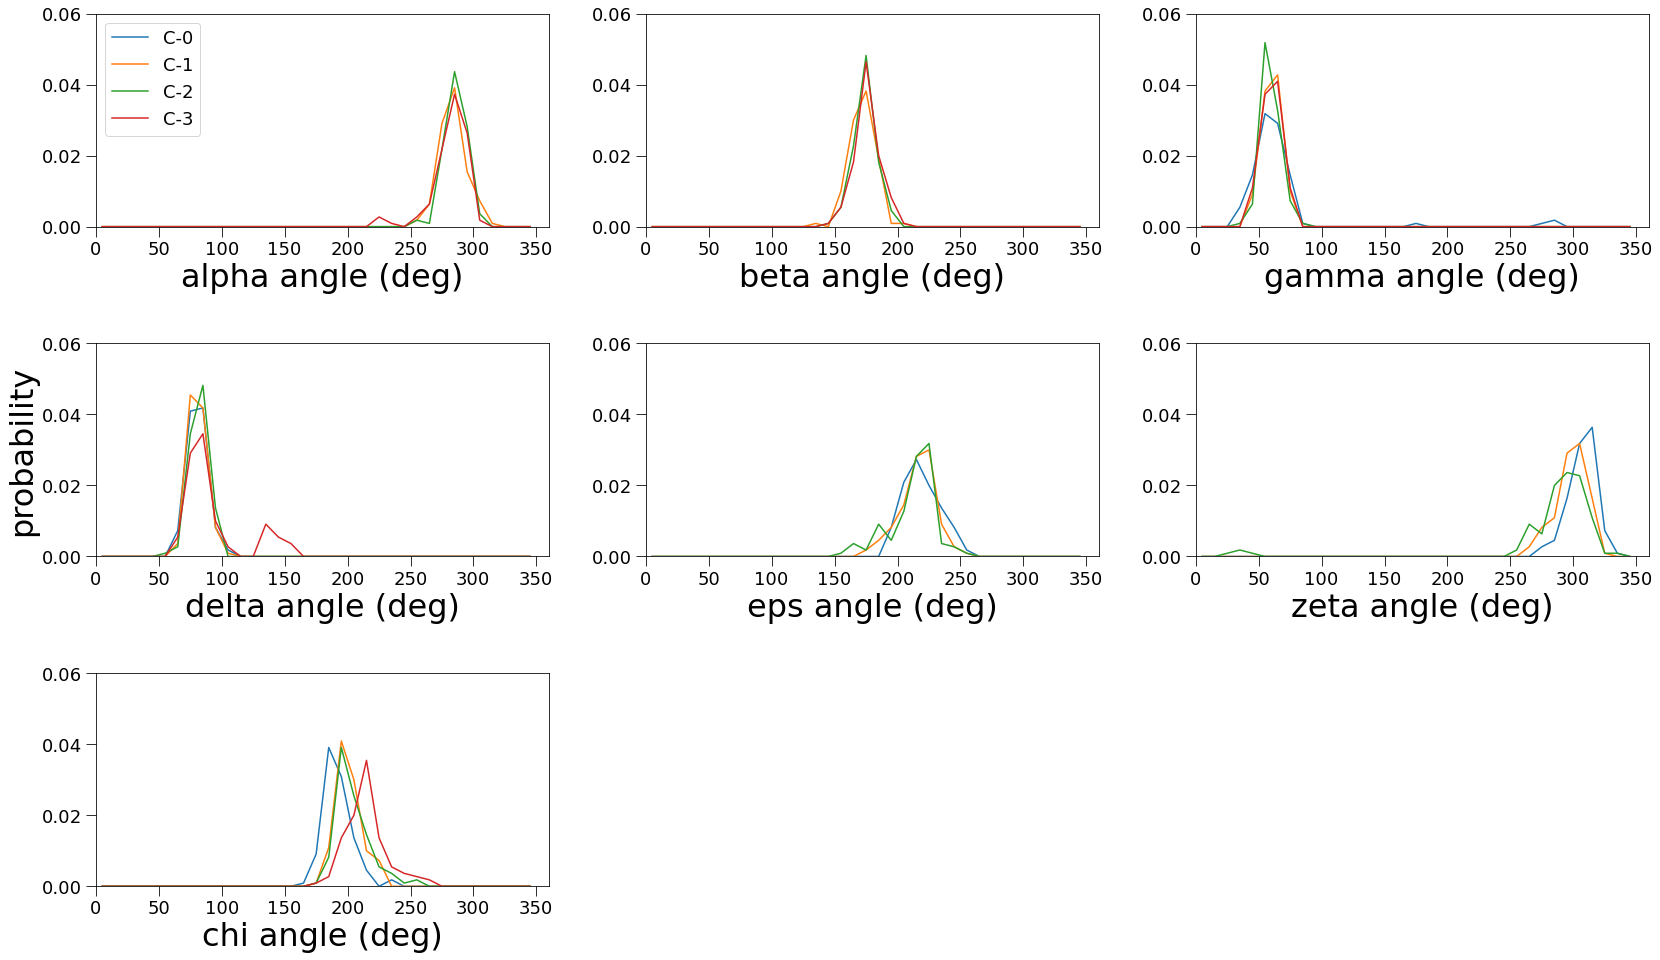

In [19]:
angles, res = bb.backbone_angles_traj(eq_traj)
#print(angles_s.shape)

# move from -pi,pi to 0-2pi range and convert radians to deg
a = radian_to_degree(np.array(angles))

# create historgram 
bins = np.arange(0, 360, 10)

# make plot
fig = plt.figure(figsize=(24,18))
for k, v in backbone_annot_dict.items():
    """
    k : torsion name
    v : torsion index
    """
    ax = fig.add_subplot(4, 3, v+1)
    for i in range(len(rnames)):
        """
        i : residue name index
        x : normalized frequency
        y : degree
        """
        y, x = np.histogram(a[:,i, v], density=True, bins=bins)
        ax.plot(0.5*(x[1:]+x[:-1]), y, label="{}-{}".format(rnames[i], i))
    if v == 0:
        plt.legend(loc="upper left", fontsize=18)
    if v == 3:
        ax.set_ylabel("probability", fontsize=32)
    ax.set_xlabel("{} angle (deg)".format(k), fontsize=32)
    ax.set_xlim(0, 360)
    ax.set_ylim(0, 0.06)
    ax.tick_params(axis='both', labelsize=18)
    #plt.text(60, 0.005, "syn", fontsize=18, ha='center')
    #plt.text(190, 0.005, "anti", fontsize=18, ha='center')
    #plt.text(260, 0.005, "high-anti", fontsize=18, ha='center')

plt.tight_layout()
plt.savefig("bb_angles_eq.png")

#### backbone angle histrogram

production

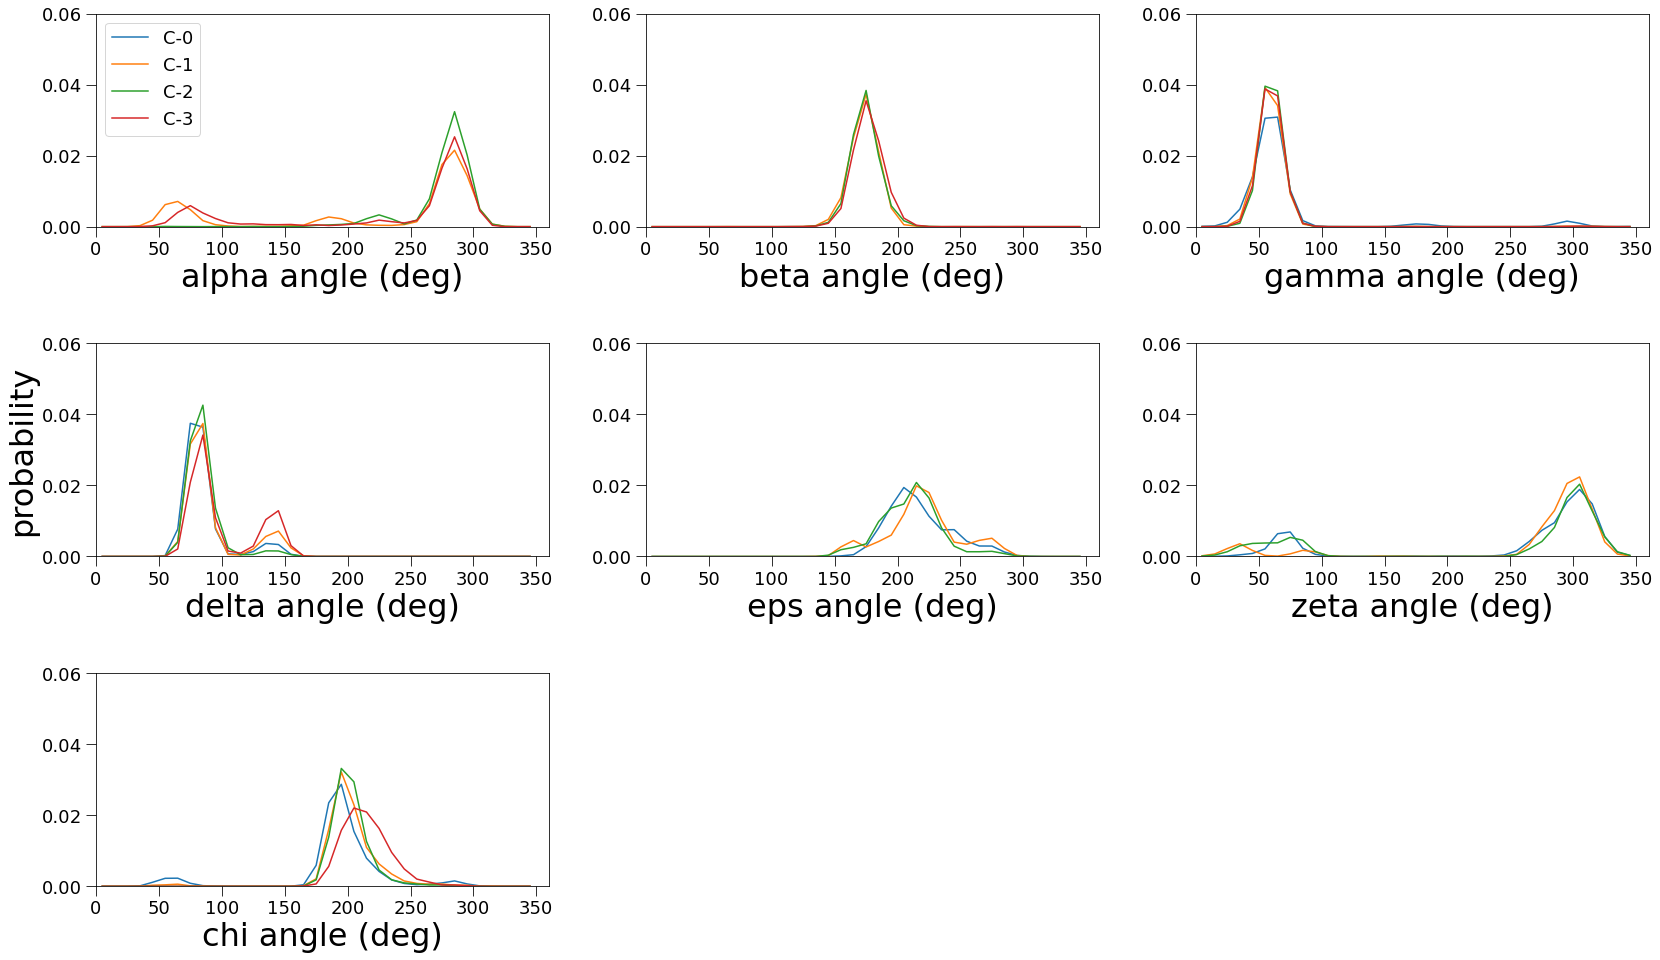

In [20]:
angles, res = bb.backbone_angles_traj(traj)
#print(angles_s.shape)

# move from -pi,pi to 0-2pi range and convert radians to deg
a = radian_to_degree(np.array(angles))

# create historgram 
bins = np.arange(0, 360, 10)

# make plot
fig = plt.figure(figsize=(24,18))
for k, v in backbone_annot_dict.items():
    """
    k : torsion name
    v : torsion index
    """
    ax = fig.add_subplot(4, 3, v+1)
    for i in range(len(rnames)):
        """
        i : residue name index
        x : normalized frequency
        y : degree
        """
        y, x = np.histogram(a[:,i, v], density=True, bins=bins)
        ax.plot(0.5*(x[1:]+x[:-1]), y, label="{}-{}".format(rnames[i], i))
    if v == 0:
        plt.legend(loc="upper left", fontsize=18)
    if v == 3:
        ax.set_ylabel("probability", fontsize=32)
    ax.set_xlabel("{} angle (deg)".format(k), fontsize=32)
    ax.set_xlim(0, 360)
    ax.set_ylim(0, 0.06)
    ax.tick_params(axis='both', labelsize=18)
    #plt.text(60, 0.005, "syn", fontsize=18, ha='center')
    #plt.text(190, 0.005, "anti", fontsize=18, ha='center')
    #plt.text(260, 0.005, "high-anti", fontsize=18, ha='center')

plt.tight_layout()
plt.savefig("bb_angles.png")

#### sugar pucker

initial structure

In [21]:
init_angles, res = bb.pucker_angles(init_pdb, topology=init_pdb)

# Loading ../../eq/solvated.pdb 


equilibration

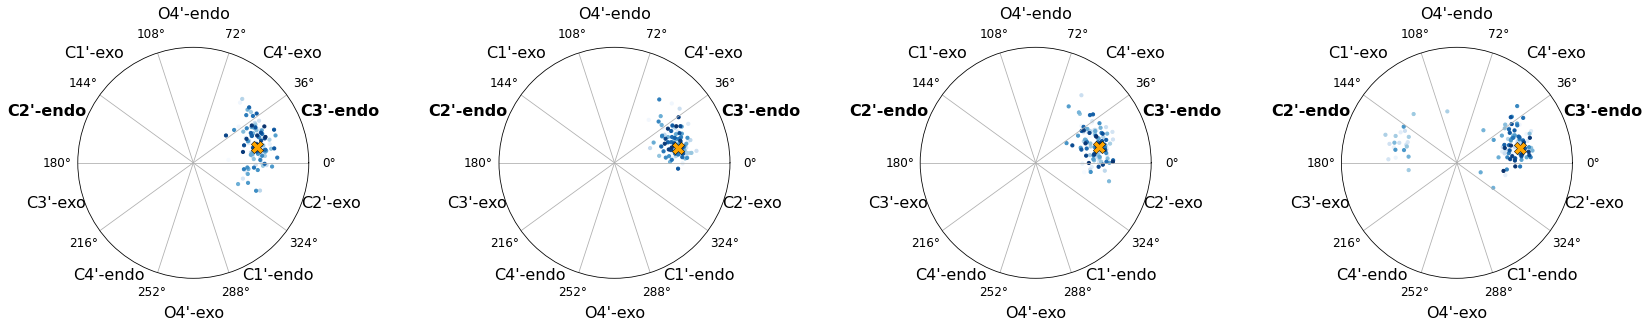

In [22]:
#angles, res = bb.pucker_angles_traj(eq_ncfile, topology=init_pdb)
angles, res = bb.pucker_rao_traj(eq_traj)

# make plot
fig = plt.figure(figsize=(24,18))
for i in range(len(rnames)):
    ax = fig.add_subplot(1, 4, i+1, polar=True)
    #ax.plot(polar=True)

    ax.scatter(angles[:,i,0], angles[:,i,1], s=10, c=np.arange(len(angles)), cmap='Blues', label="{}-{}".format(rnames[i], i))
    ax.scatter(init_angles[:,i,0], init_angles[:,i,1], marker="X", c="orange", edgecolors="black", s=150, linewidths=0.5)
    
    p3 = np.pi/5
    ax.text(0.5*p3, 1.6, "C3'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(1.3*p3, 1.5, "C4'-exo",  ha='center', fontsize=16)
    ax.text(2.5*p3, 1.5, "O4'-endo", ha='center', fontsize=16)
    ax.text(3.7*p3, 1.5, "C1'-exo",  ha='center', fontsize=16)
    ax.text(4.5*p3, 1.6, "C2'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(5.5*p3, 1.5, "C3'-exo",  ha='center', fontsize=16)
    ax.text(6.5*p3, 1.5, "C4'-endo", ha='center', fontsize=16)
    ax.text(7.5*p3, 1.6, "O4'-exo",  ha='center', fontsize=16)
    ax.text(8.5*p3, 1.5, "C1'-endo", ha='center', fontsize=16)
    ax.text(9.5*p3, 1.5, "C2'-exo",  ha='center', fontsize=16)
    
    xt = np.arange(0, 2*np.pi, p3)
    ax.set_xticks(xt)
    ax.set_yticks([])
    ax.set_ylim(0, 1.2)
    ax.tick_params(axis='both', labelsize=12)
    
    plt.tight_layout()
    #plt.legend(loc="upper center")
    plt.savefig("pucker_anlges_eq.png")

production

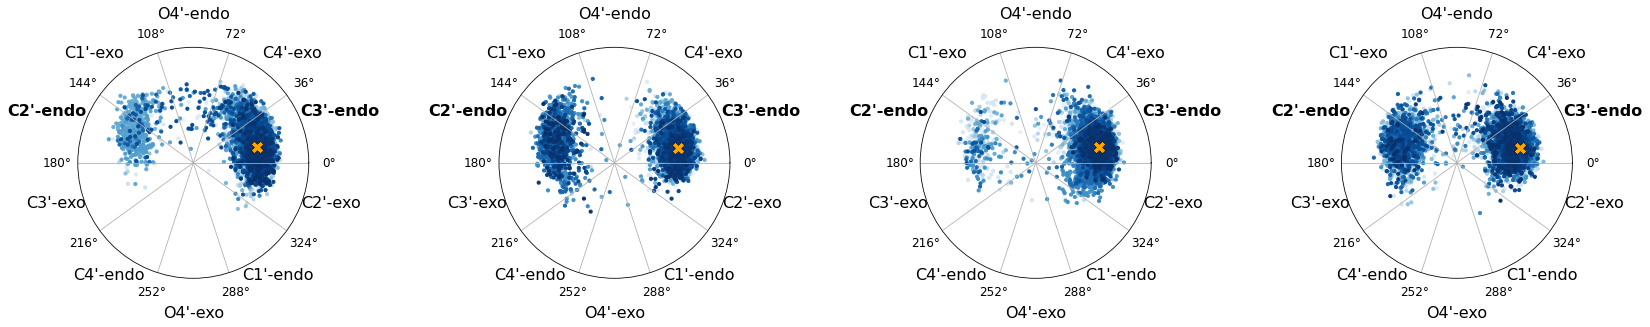

In [23]:
#angles, res = bb.pucker_angles(ncfiles, topology=init_pdb)
angles, res = bb.pucker_rao_traj(traj)

# make plot
fig = plt.figure(figsize=(24,18))
for i in range(len(rnames)):
    ax = fig.add_subplot(1, 4, i+1, polar=True)
    #ax.plot(polar=True)

    ax.scatter(angles[:,i,0], angles[:,i,1], s=10, c=np.arange(len(angles)), cmap='Blues', label="{}-{}".format(rnames[i], i))
    ax.scatter(init_angles[:,i,0], init_angles[:,i,1], marker="X", c="orange", edgecolors="black", s=150, linewidths=0.5)
    
    p3 = np.pi/5
    ax.text(0.5*p3, 1.6, "C3'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(1.3*p3, 1.5, "C4'-exo",  ha='center', fontsize=16)
    ax.text(2.5*p3, 1.5, "O4'-endo", ha='center', fontsize=16)
    ax.text(3.7*p3, 1.5, "C1'-exo",  ha='center', fontsize=16)
    ax.text(4.5*p3, 1.6, "C2'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(5.5*p3, 1.5, "C3'-exo",  ha='center', fontsize=16)
    ax.text(6.5*p3, 1.5, "C4'-endo", ha='center', fontsize=16)
    ax.text(7.5*p3, 1.6, "O4'-exo",  ha='center', fontsize=16)
    ax.text(8.5*p3, 1.5, "C1'-endo", ha='center', fontsize=16)
    ax.text(9.5*p3, 1.5, "C2'-exo",  ha='center', fontsize=16)
    
    xt = np.arange(0, 2*np.pi, p3)
    ax.set_xticks(xt)
    ax.set_yticks([])
    ax.set_ylim(0, 1.2)
    ax.tick_params(axis='both', labelsize=12)
    
    plt.tight_layout()
    #plt.legend(loc="upper center")
    plt.savefig("pucker_anlges.png")

# Radius of gyration

#### Rg histogram

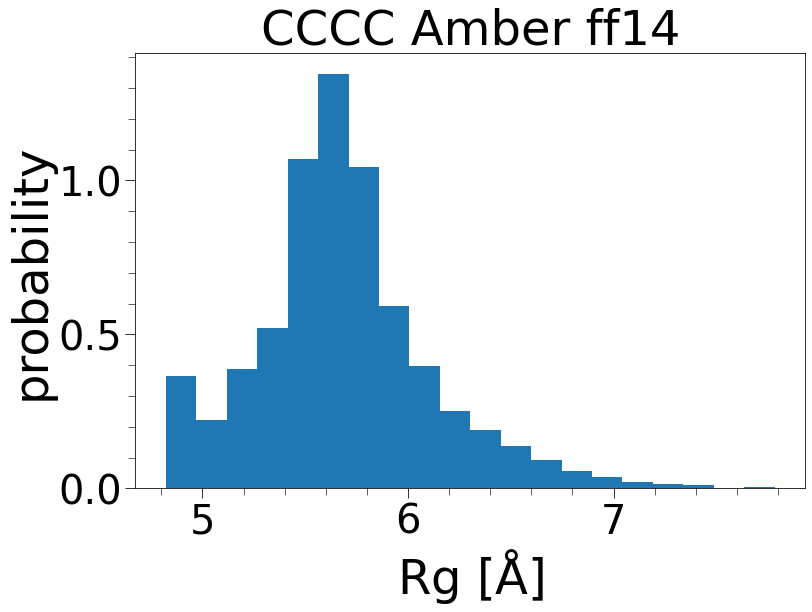

In [24]:
# calculate
atom_indices = traj.topology.select('not (protein or water or symbol Na or symbol Cl)')
t = traj.atom_slice(atom_indices)
rg = mdtraj.compute_rg(t)
rg = np.array(rg) * UNIT_NM_TO_ANGSTROMS   # convert nm to angstroms

# define
fig, ax = plt.subplots(figsize=(12, 8))

# title
ax.set_title(PLOT_TITLE)

# x-axis
ax.set_xlabel(r'Rg [${\rm \AA}$]')
#ax.xaxis.set_ticks(np.arange(0, 1, 0.2))
ax.xaxis.set_minor_locator(AutoMinorLocator())
#ax.set_xlim([]) 

# y-axis
ax.set_ylabel('probability')
#ax.yaxis.set_ticks(np.arange(0, 1, 0.2))
#ax.yaxis.set_minor_locator(MultipleLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_ylim([])

# plot
ax.hist(rg, bins=20, density=True)

#plt.show()
plt.savefig("rg_hist.png")

#### Rg time plot

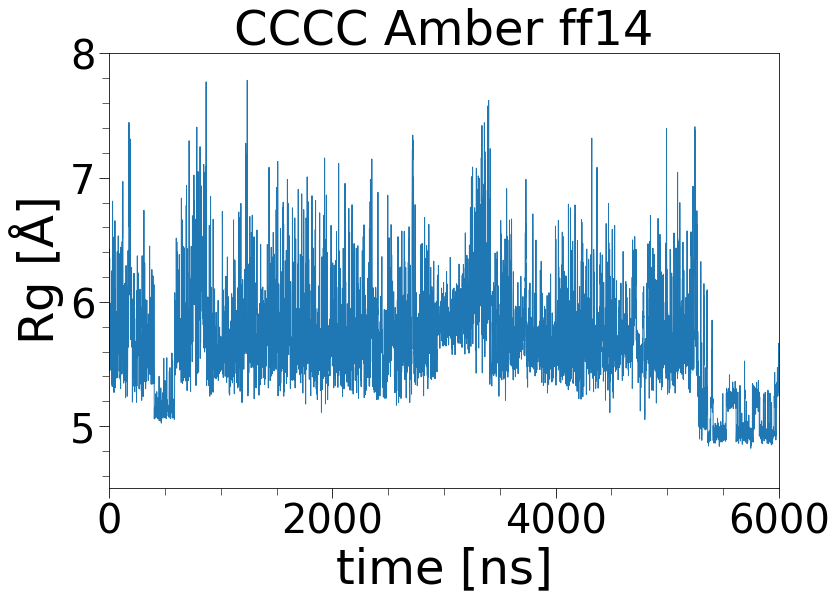

In [27]:
x = np.arange(1, len(rg)+1) * LOGGING_FREQUENCY * STRIDE * UNIT_PS_TO_NS

# define
fig, ax = plt.subplots(figsize=(12, 8))

# title
ax.set_title(PLOT_TITLE)

# x-axis
ax.set_xlabel(r'time [ns]')
#ax.xaxis.set_ticks(np.arange(0, 1, 0.2))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim([0, len(x)]) 

# y-axis
ax.set_ylabel(r'Rg [${\rm \AA}$]')
#ax.yaxis.set_ticks(np.arange(0, 1, 0.2))
#ax.yaxis.set_minor_locator(MultipleLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylim([4.5, 8])

# plot
ax.plot(x, rg, lw=1)

#plt.show()
plt.savefig("rg.png")

# RMSD and eRMSD

RMSD:  Calculate rmsd after optimal alignment between reference and target structures. Superposition and RMSD calculations are performed using all heavy atoms. If the sequence of reference and target is different, only backbone/sugar heavy atoms are used.  
eRMSD: Calculate ermsd between reference and target structures  

#### RMSD time plot

# found  45 atoms in common


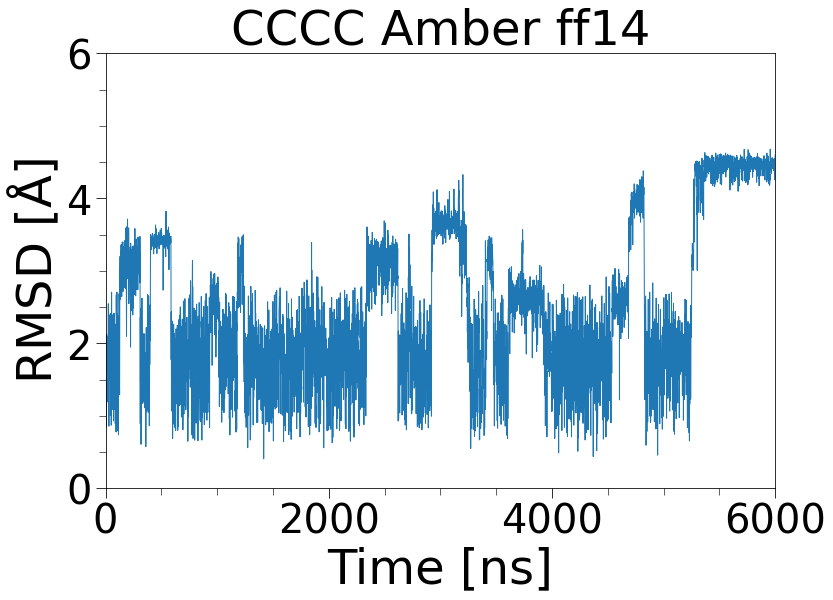

In [28]:
# calculate
rmsd = list(bb.functions.rmsd_traj(ref_traj, traj))   
rmsd = np.array(rmsd) * UNIT_NM_TO_ANGSTROMS

x = np.arange(1, len(rg)+1) * LOGGING_FREQUENCY * STRIDE * UNIT_PS_TO_NS

# define
fig, ax = plt.subplots(figsize=(12, 8))

# title
ax.set_title(PLOT_TITLE)

# x-axis
ax.set_xlabel(r'Time [ns]')
#ax.xaxis.set_ticks(np.arange(0, 1, 0.2))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim([0, len(x)]) 

# y-axis
ax.set_ylabel(r'RMSD [${\rm \AA}$]')
#ax.yaxis.set_ticks(np.arange(0, 1, 0.2))
#ax.yaxis.set_minor_locator(MultipleLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylim([0, 6])

# plot
ax.plot(x, rmsd, lw=1)

#plt.show()
plt.savefig("rmsd.png")

#### eRMSD time plot

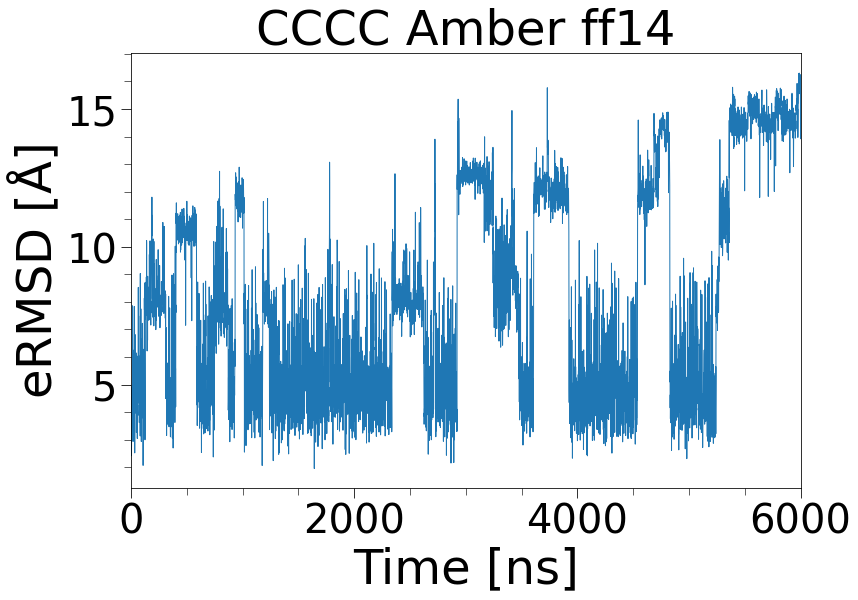

In [29]:
# calculate
ermsd = list(bb.functions.ermsd_traj(ref_traj, traj))   
ermsd = np.array(ermsd) * UNIT_NM_TO_ANGSTROMS


# define
fig, ax = plt.subplots(figsize=(12, 8))

# title
ax.set_title(PLOT_TITLE)

# x-axis
ax.set_xlabel(r'Time [ns]')
#ax.xaxis.set_ticks(np.arange(0, 1, 0.2))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim([0, len(x)]) 

# y-axis
ax.set_ylabel(r'eRMSD [${\rm \AA}$]')
#ax.yaxis.set_ticks(np.arange(0, 1, 0.2))
#ax.yaxis.set_minor_locator(MultipleLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_ylim([0, 6])

# plot
ax.plot(x, ermsd, lw=1)

#plt.show()
plt.savefig("ermsd.png")

#### RMSD and eRMSD side-by-side plot

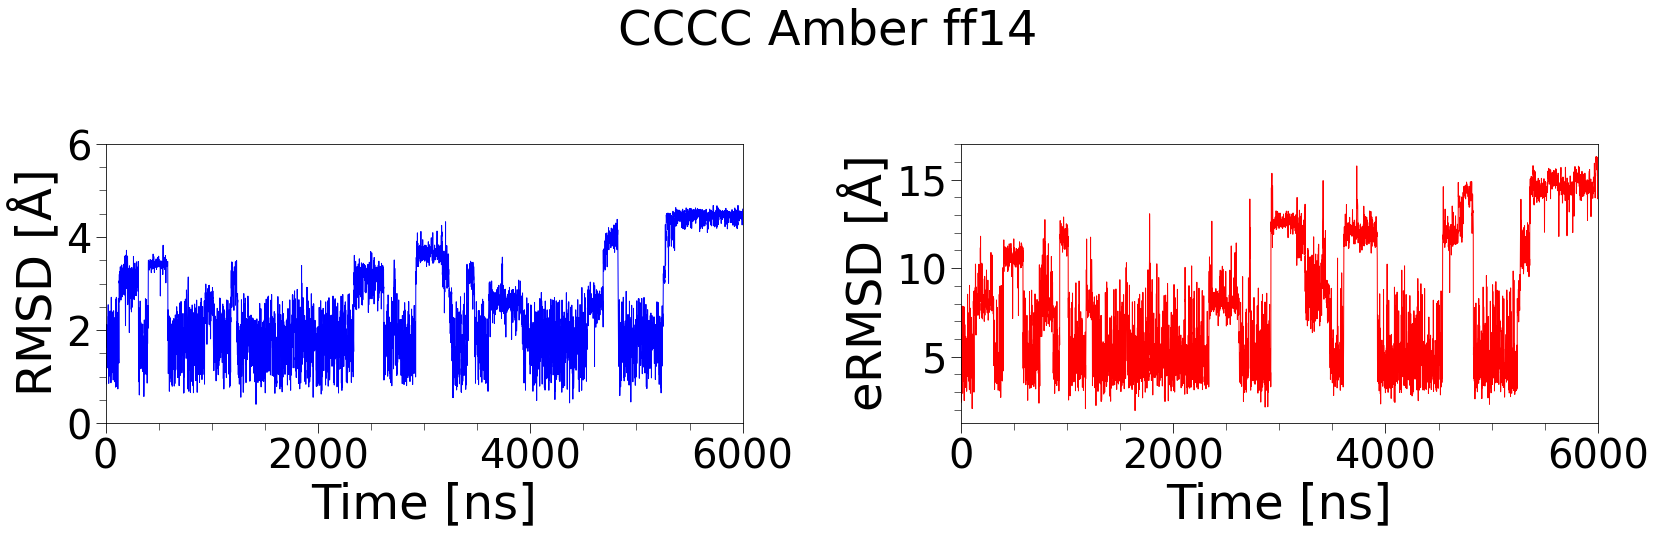

In [30]:
# define
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 8))

# title
fig.suptitle(PLOT_TITLE)

# xy-axis (1)
ax1.set_xlabel(r'Time [ns]')
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.set_xlim([0, len(x)]) 
ax1.set_ylabel(r'RMSD [${\rm \AA}$]')
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.set_ylim([0, 6])

# xy-axis (2)
ax2.set_xlabel(r'Time [ns]')
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.set_xlim([0, len(x)]) 
ax2.set_ylabel(r'eRMSD [${\rm \AA}$]')
ax2.yaxis.set_minor_locator(AutoMinorLocator())
#ax2.set_ylim([0, 6])

# plot
ax1.plot(x, rmsd, lw=1, c='b')
ax2.plot(x, ermsd, lw=1, c='r')

plt.tight_layout()
#plt.show()
plt.savefig("rmsd_ermsd.png")

# Annotation ([srnas/barnaba/examples/example_03_annotate.ipynb](https://github.com/srnas/barnaba/blob/master/examples/example_03_annotate.ipynb))

`stackings, pairings, res = bb.annotate(pdb)`  

returns three lists:

- a list of stacking interactions
- a list of pairing interactions
- the list of residue names following the usual convention RESNAME_RESNUMBER_CHAININDEX

`stackings` and `pairings` contain the list of interactions for the N frames in the PDB/trajectory file and it is organized in the following way: for a given frame there are interactions between residues with index pairings`[i][0][k][0]` and `pairings[i][0][k][1]`. The type of interaction is specified at the element `pairings[i][1][k]`.

### Decypher the annotation  ###
Base-pairing are classified according to the Leontis-Westhof classification, where 
- W = Watson-Crick edge
- H = Hoogsteeen edge 
- S= Sugar edge
- c/t = cis/trans
- XXx = when two bases are close in space, but they do not fall in any of the categories. This happens frequently for low-resolution structures or from molecular simulations.

WWc pairs between complementary bases are called WCc or GUc.  
Stacking are classified according to the MCannotate classification:
- ">>" Upward
- "<<" Downward 
- "<>" Outward
- "><" Inward



### Criteria for stacking/pairing ###
First, we consider only bases that are "close" in space, i.e. $R_{ij} < 1.7$ and $R_{ji} < 1.7$.  
$R_{ij} = (x_{ij}/5, y_{ij}/5, z_{ij}/3)$ is the SCALED position vector with components ${x,y,z}$ (in $\mathring{A}$) of base j constructed on base i.  
The criteria for *base-stacking* are the following:

$( |z_{ij}| \; AND \; |z_{ji}| > 2 \mathring{A} ) \; AND \;  
(\rho_{ij} \; OR\; \rho_{ji} < 2.5 \mathring{A}) \; AND\;  
(|\theta_{ij}| < 40^{\circ} ) $ 

where
- $ \rho_{ij} = \sqrt{x_{ij}^2 + y_{ij}^2} $  
- $\theta_{ij}$ = angle between the vectors normal to the base plane

The criteria for *base-pairing* are the following:  

non stacked AND $|\theta_{ij}| < 60^{\circ}$ AND (number of hydrogen bonds $> 0$)  
The number of hydrogen bonds is calculated as the number of donor-acceptor pairs with distance $< 3.3 \mathring{A}$. 
If bases are complementary and the number of hydrogen bonds is > 1 (AU/GU) or > 2 (GC), the pair is considered WCc (or GUc).

- cis/trans is calculated according to the value of the dihedral angle defined by $C1'_{i}-N1/N9_{i}-N1/N9_{j}-C1'_{j}$
- edges are definded according to the value of $\psi = \arctan{(\hat{y}_{ij}/\hat{x}_{ij})}$. 
    1. Watson-Crick edge: $0.16 <\psi \le 2.0 rad$ 
    2. Hoogsteen edge:  $2.0 <\psi \le 4.0 rad $. 
    3. Sugar edge: $\psi > 4.0, \psi \le 0.16$

    
**ATT!**
- These criteria are slightly different from the one used in other popular software for annotating three-dimensional structures (e.g. X3DNA, MCAnnotate, Fr3D, etc.). From my experience, all these packages give slightly different results, especially for non-Watson-Crick base-pairs.
- Stacking is also problematic, as it relies on arbitrary criteria.
- In all cases, criteria for stacking and pairing were calibrated to work well for high resolution structures. These criteria might not be optimal for low-resolution structures and to describe nearly-formed interactions such the ones that are often encountered in molecular simulations.

### Dot-bracket annotation ###

From the list of base-pairing, we can obtain the dot-bracket annotation using the function
```python
dotbracket = bb.dot_bracket(pairings,res)
```
this function returns a string for each frame in the PDB/simulation. Let's see this in action:


### Symbols for base stacking from François Major’s group ([RNA 3D Structure Course](https://docs.google.com/document/d/173tvcKJgAUmjd03zIKLz-_KCNTlcHBNDWlDfDtMhxmU/edit#) by Craig L. Zirbel and Neocles Leontis at Bowling Green State Universtiy)

Two possible orientations of two stacked bases result in four base-stacking types: upward (>>), downward (<<), outward (<>) and inward (><). Two arrows pointing in the same direction (upward and downward) corresponds to the stacking type in the canonical A-RNA double-helix. Upward or downward is chosen depending on which base is referred first (i.e. A>>B means B is stacked upward of A, or A is stacked downward of B). The two other types are less frequent in RNAs, respectively inward (A><B; A or B is stacked inward of, respectively B or A) and outward (A<>B; A or B is stacked outward of, respectively B or A). 

#### minimized structure

In [31]:
stackings, pairings, res = bb.annotate(ref_pdb, topology=init_pdb)

# Loading ../../eq/min.pdb 


In [32]:
# list base pairings
print("BASE-PAIRS")
for p in range(len(pairings[0][0])):
    res1 = res[pairings[0][0][p][0]]
    res2 = res[pairings[0][0][p][1]]
    interaction =  pairings[0][1][p]
    print("%10s %10s %4s" % (res1,res2,interaction))

# list base-stackings
print("STACKING")
for p in range(len(stackings[0][0])):
    res1 = res[stackings[0][0][p][0]]
    res2 = res[stackings[0][0][p][1]]
    interaction =  stackings[0][1][p]
    print("%10s %10s %4s" % (res1,res2,interaction))

BASE-PAIRS
STACKING
     C_1_0      C_2_0   >>
     C_3_0      C_4_0   >>


#### production

In [33]:
# stacking and pairing
stackings, pairings, res = bb.annotate_traj(traj, stacking_rho_cutoff=4.0, stacking_angle_cutoff=45)

# pucker
pucker_angles, _ = bb.pucker_rao_traj(traj)
pucker_angles = radian_to_degree(pucker_angles)  # phase, amplitude

# backbone
bb_angles, _ = bb.backbone_angles_traj(traj, )
bb_angles = radian_to_degree(bb_angles) # alpha, beta, gamma, delta, eps, zeta, chi

# define individual angles
alpha = bb_angles[:,:,0]
beta = bb_angles[:,:,1]
gamma = bb_angles[:,:,2]
delta = bb_angles[:,:,3]
eps = bb_angles[:,:,4]
zeta = bb_angles[:,:,5]
chi = bb_angles[:,:,6]
phase = pucker_angles[:,:,0]

In [34]:
# N1 distance
atom_indices = ref_traj.topology.select('name N1')

# distance between first (5'-end) and second N1 atom
dist1 = mdtraj.compute_distances(traj, atom_pairs=atom_indices[:2].reshape(1,2))
dist1 = dist1 * UNIT_NM_TO_ANGSTROMS

# distance between second and third (3'-end) N1 atom
dist2 = mdtraj.compute_distances(traj, atom_pairs=atom_indices[1:3].reshape(1,2))
dist2 = dist2 * UNIT_NM_TO_ANGSTROMS

# distance between third and fourth (3'-end) N1 atom
dist3 = mdtraj.compute_distances(traj, atom_pairs=atom_indices[2:].reshape(1,2))
dist3 = dist3 * UNIT_NM_TO_ANGSTROMS

In [75]:
myclass = []
flipping_cutoff = 7

for frame_idx in range(len(stackings)):
    """
    stackings[frame_idx] : list
        e.g. [[[0, 1], [1, 2], [2, 3]], ['>>', '>>', '>>']]
    """
    stacking_residue_index = stackings[frame_idx][0]
    stacking_pattern = stackings[frame_idx][1]
        
        
    # 1) Define c3'-endo and c2'-endo using δ torsion angles
    #    C3'-endo: an individual ribose with δ between 55° and 110°
    #    C2'-endo: an individual ribose with δ between 120° and 175°
    #    Ref: RNA backbone: Consensus all-angle conformers and modular string nomenclature (an RNA Ontology Consortium contribution), RNA 2008
    # 2) Define by pucker phase angle: C3' -endo [0°, 36°) as in canonical RNA and A-form DNA, and the C2'-endo [144°, 180°)
    c3_endo, c2_endo = [], []
    for _delta, _phase in zip(delta[frame_idx], phase[frame_idx]):
        if (_delta >= 55 and _delta < 110) or (_phase >=0 and _phase < 36):
            c3_endo.append(1)
        else:
            c3_endo.append(0)
        if (_delta >= 120 and _delta < 175) or (_phase >= 144 and _phase < 180):
            c2_endo.append(1)
        else:
            c2_endo.append(0)


    name = ""
    
    #
    # A-form
    #
    #if len(stacking_pattern) == 3 and sum(c3_endo) == len(rnames):
    if len(stacking_pattern) == 3:
        # AMa: A-form major (3'-end backbone gamma-torsion +gauche)
        #if gamma[frame_idx, -1] >= 30 and gamma[frame_idx, -1] < 90:
            #name = "AMa"
            
        # AMi: A-form minor (3'-end backbone gamma-torsion is trans)
        #if alpha[frame_idx, -1] >= 150 and alpha[frame_idx, -1] < 210:    
            #name = "AMi"
        
        if sum(c3_endo) == len(rnames):
            name = "AMa"
        else:
            name = "AMi"


    # Alternative:
    # Use nomenclature definition 1a (delta-epsilon-zeta: 3'-em and alpha-beta-gamma-delta: mtp3') from 
    # Ref: RNA backbone: Consensus all-angle conformers and modular string nomenclature (an RNA Ontology Consortium contribution), RNA 2008
    #
    # 3': delta 55 to 110
    # -e: -120 +- 25 (A-?) -> 215 to 265
    # m: -60 (gauche-) -> 270 to 330
    # t: 180 (T) -> 150 to 210
    # p: 60 (gauche+) -> 30 to 90
    # e: 120 +- 25 (A+) -> 95 to 145
    
    count = 0
    # delta (C3'-endo): i+1, i+2, i+3, i+4 -> 3'
    if sum(c3_endo) == len(rnames):
        count+=1
    # epsilon (i, i+1, i+2) -> -e
    if np.all(np.logical_and(eps[frame_idx][:len(eps[frame_idx])-1] >= 215, eps[frame_idx][:len(eps[frame_idx])-1] < 265)):
        count+=1
    # zeta (i, i+1, i+2) -> m
    if np.all(np.logical_and(zeta[frame_idx][:len(zeta[frame_idx])-1] >= 270, zeta[frame_idx][:len(zeta[frame_idx])-1] < 330)):
        count+=1
    # alpha (i+1, i+2, i+3) -> m
    if np.all(np.logical_and(alpha[frame_idx][1:] >= 270, alpha[frame_idx][1:] < 330)):
        count+=1
    # beta (i+1, i+2, i+3) -> t
    if np.all(np.logical_and(beta[frame_idx][1:] >= 150, beta[frame_idx][1:] < 210)):
        count+=1
    # gamma (i, i+1, i+2, i+3) -> p
    if np.all(np.logical_and(beta[frame_idx] >= 30, beta[frame_idx] < 90)):
        count+=1

    if count == 6:
        # AMa: A-form major (3'-end backbone gamma-torsion +gauche)
        if gamma[frame_idx, -1] >= 30 and gamma[frame_idx, -1] < 90:
            name = "AMa-"
            
        # AMi: A-form minor (3'-end backbone gamma-torsion is trans)
        if gamma[frame_idx, -1] >= 150 and gamma[frame_idx, -1] < 210:    
            name = "AMi-"
    
    #
    # I: Intercaleted (nucleotide j inserts between and stacks against nb i and i+1)            
    #
    # check if stacking residues are from i and i+1
    # exclude stacking_residue_index=[0, 3] (i.e., 5'- and 3'-end stacking )
    # exclude stacking_residue_index=[0, 2]
    #if ([1, 3] in stacking_residue_index and [1, 2] in stacking_residue_index):
    if [0, 1] in stacking_residue_index and [0, 2] in stacking_residue_index:
        if name != "":
            print("{}: overwrite {} to I1".format(frame_idx+1, name))
        name = "I1"
    if [0, 2] in stacking_residue_index and [0, 3] in stacking_residue_index:
        if name != "":
            print("{}: overwrite {} to I2".format(frame_idx+1, name))
        name = "I2"
    if [1, 2] in stacking_residue_index and [1, 3] in stacking_residue_index:
        if name != "":
            print("{}: overwrite {} to I3".format(frame_idx+1, name))
        name = "I3"
    if [0, 2] in stacking_residue_index and [1, 2] in stacking_residue_index:
        if name != "":
            print("{}: overwrite {} to I4".format(frame_idx+1, name))
        name = "I4"
    if [0, 3] in stacking_residue_index and [1, 3] in stacking_residue_index:
        if name != "":
            print("{}: overwrite {} to I5".format(frame_idx+1, name))
        name = "I5"
    if [1, 3] in stacking_residue_index and [2, 3] in stacking_residue_index:
        if name != "":
            print("{}: overwrite {} to I6".format(frame_idx+1, name))
        name = "I6"

        
    #          
    # Base flipping (distance, 
    # https://pubs.acs.org/doi/10.1021/acs.jpcb.2c00340
    #
    
    # F1: Nucleotide-1 flipped (ribose ring of the terminal nucleotide adopts the C2'-endo configuration and the base is flipped away from the other three)
    # 1) 5'-end is C2 endo
    # 2) Exlculde stacking_residue_index=[0,1] and confirm all other nb are stacking (i.e., stacking_pattern = ['>>', '>>'])
    # 3) N1 distance between first and second nb is greater than flippling_dist_cutoff
    if c2_endo[0] == 1 and len(stacking_pattern) == 2 and [0, 1] not in stacking_residue_index and dist1[frame_idx] > flipping_cutoff:
        if name != "":
            print("{}: overwrite {} to F1".format(frame_idx+1, name))
        name = "F1"

    #if c2_endo[1] == 1 and len(stacking_pattern) == 2 and [1, 2] not in stacking_residue_index and dist1[frame_idx] > flipping_cutoff and dist2[frame_idx] > flipping_distance:
    #    if name != "":
    #        print("{}: overwrite {} to F2".format(frame_idx+1, name))
    #    name = "F2"        
        
    #if c2_endo[2] == 1 and len(stacking_pattern) == 2 and [2, 3] not in stacking_residue_index and dist2[frame_idx] > flipping_cutoff and dist3[frame_idx] > flipping_distance:
    #    if name != "":
    #        print("{}: overwrite {} to F3".format(frame_idx+1, name))
    #    name = "F3"                
        
    if c2_endo[-1] == 1 and len(stacking_pattern) == 2 and [2, 3] not in stacking_residue_index and dist3[frame_idx] > flipping_cutoff:
    #if [2, 3] not in stacking_residue_index and stacking_pattern == ['>>', '>>'] and dist3[frame_idx] > flipping_cutoff:
        if name != "":
            print("{}: overwrite {} to F4".format(frame_idx+1, name))        
        name = "F4"

        
        
    #
    # O: Others (all others)
    #
    if name == "":
        name = "O"
    
    
    
    myclass.append(name)
    #print(frame_idx+1, name, stacking_residue_index, stacking_pattern, pairing_residue_index, pairing_pattern, phase[i,:], delta[i,:], gamma[i,:])
    #print(frame_idx+1, name)
    #print(stacking_residue_index, stacking_pattern)
    #print(list(alpha[frame_idx,:]), list(beta[frame_idx,:]), list(gamma[frame_idx,:]), list(delta[frame_idx,:]), list(eps[frame_idx,:]), list(zeta[frame_idx,:]), list(phase[frame_idx,:]), dist1[frame_idx], dist2[frame_idx], dist3[frame_idx], c3_endo, c2_endo)
    with open("log.txt", "a") as wf:
        wf.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(frame_idx+1, 
                                                                                               name, 
                                                                                               stacking_residue_index, 
                                                                                               stacking_pattern, 
                                                                                               list(alpha[frame_idx,:]), 
                                                                                               list(beta[frame_idx,:]), 
                                                                                               list(gamma[frame_idx,:]), 
                                                                                               list(delta[frame_idx,:]), 
                                                                                               list(eps[frame_idx,:]), 
                                                                                               list(zeta[frame_idx,:]), 
                                                                                               list(phase[frame_idx,:]), 
                                                                                               dist1[frame_idx], 
                                                                                               dist2[frame_idx], 
                                                                                               dist3[frame_idx], 
                                                                                               c3_endo, 
                                                                                               c2_endo))

1949: overwrite AMa to I6
4759: overwrite AMi to I1
4800: overwrite AMa to I1
5366: overwrite AMi to I2
5366: overwrite I2 to I4
5369: overwrite AMa to I2
5369: overwrite I2 to I4
5370: overwrite AMa to I2
5370: overwrite I2 to I4
5371: overwrite AMa to I2
5371: overwrite I2 to I4
5373: overwrite AMa to I2
5373: overwrite I2 to I4
5374: overwrite I4 to F4
5376: overwrite AMi to I2
5376: overwrite I2 to I4
5377: overwrite AMi to I2
5377: overwrite I2 to I4
5378: overwrite AMi to I2
5378: overwrite I2 to I4
5379: overwrite AMa to I2
5379: overwrite I2 to I4
5383: overwrite AMa to I2
5383: overwrite I2 to I4
5384: overwrite AMa to I2
5384: overwrite I2 to I4
5387: overwrite I4 to F4
5388: overwrite AMa to I2
5388: overwrite I2 to I4
5389: overwrite AMa to I2
5389: overwrite I2 to I4
5412: overwrite AMa to I2
5412: overwrite I2 to I4
5415: overwrite AMa to I2
5415: overwrite I2 to I4
5416: overwrite AMa to I2
5416: overwrite I2 to I4
5418: overwrite AMa to I2
5418: overwrite I2 to I4
5424:

In [76]:
print(len(myclass))

6000


In [77]:
from collections import Counter
d = Counter(myclass)

mydata = {
    "AMa":  d["AMa"], \
    "AMa-": d["AMa-"], \
    "AMi":  d["AMi"], \
    "AMi-": d["AMi-"], \
    "I1":   d["I1"], \
    "I2":   d["I2"], \
    "I3":   d["I3"], \
    "I4":   d["I4"], \
    "I5":   d["I5"], \
    "I6":   d["I6"], \
    "F1":   d["F1"], \
    "F4":   d["F4"], \
    "O":    d["O"]
}

In [78]:
mydata = {
    "AMa": 100*(d["AMa"]+d["AMa-"])/len(myclass), \
    "AMi": 100*(d["AMi"]+d["AMi-"])/len(myclass), \
    "I":   100*(d["I1"]+d["I2"]+d["I3"]+d["I4"]+d["I5"]+d["I6"])/len(myclass), \
    "F1":  100*d["F1"]/len(myclass), \
    "F4":  100*d["F4"]/len(myclass), \
    "O":   100*d["O"]/len(myclass)
}

mycolor = ["green", "blue", "red", "magenta", "orange", "black"]

In [79]:
# rmsd scatter plot
color = []
for _ in myclass:
    if _ == "AMa":
        color.append("green")
    elif _ == "AMi":
        color.append("blue")
    elif _ in ["I1", "I2", "I3", "I4", "I5", "I6"]:
        color.append("red")
    elif _ in "F1":
        color.append("magenta")
    elif _ == "F4":
        color.append("orange")
    elif _ == "O":
        color.append("black")
    else:
        print("undefined {}".format(_))
        color.append("white")

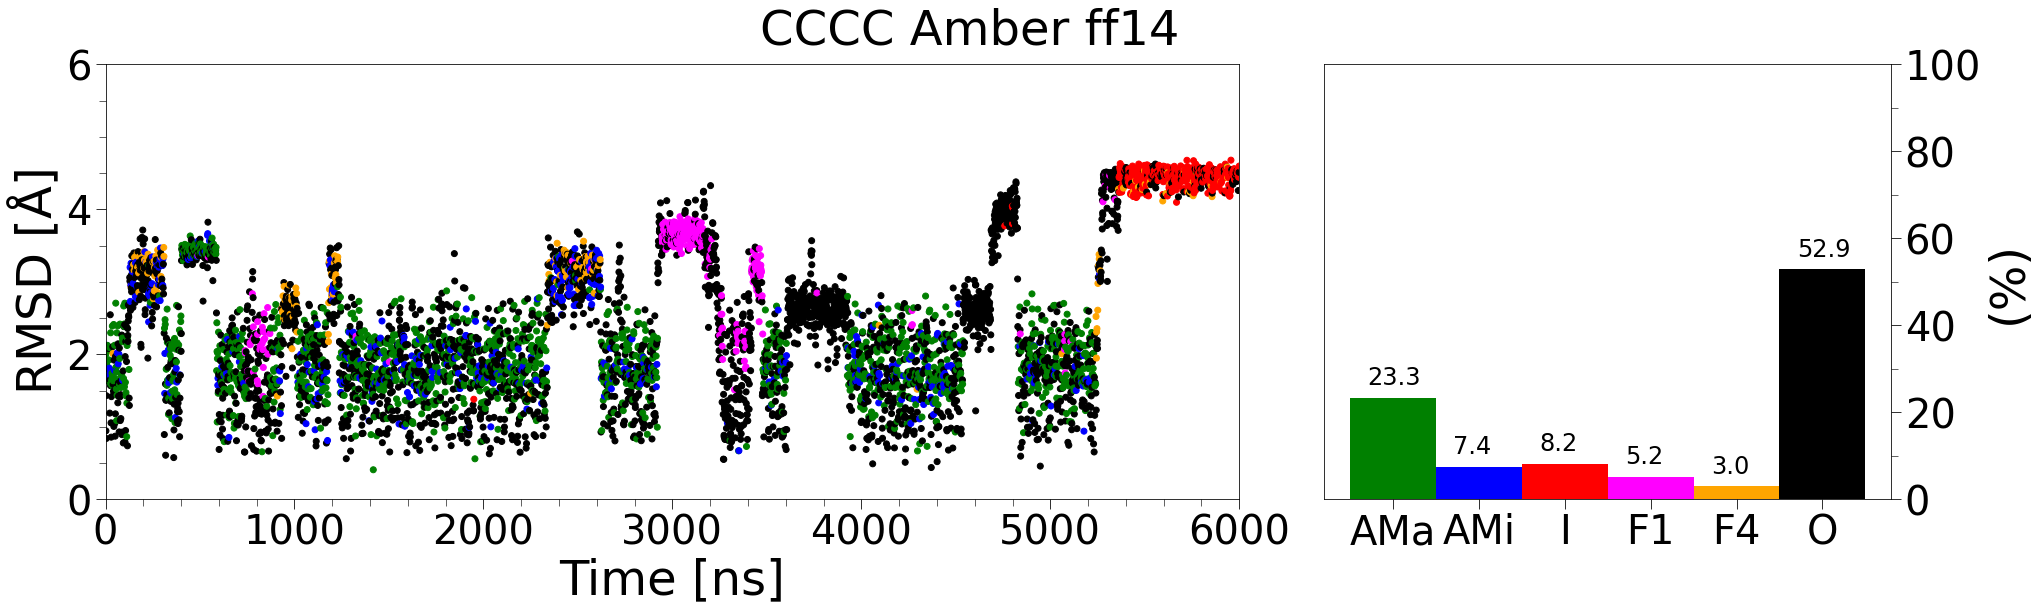

In [80]:
# define
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(32, 8), gridspec_kw={'width_ratios': [2, 1]})

# title
fig.suptitle(PLOT_TITLE)

# xy-axis (1)
ax1.set_xlabel(r'Time [ns]')
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.set_xlim([0, len(x)]) 
ax1.set_ylabel(r'RMSD [${\rm \AA}$]')
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.set_ylim([0, 6])

# xy-axis (2)
#ax2.set_xlabel(r'')
#ax2.xaxis.set_minor_locator(AutoMinorLocator())
#ax2.set_xlim([0, len(x)]) 
ax2.set_ylabel('(%)')
ax2.yaxis.set_label_position("right")
#ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(MultipleLocator(10))
ax2.yaxis.set_ticks_position("right")
ax2.set_ylim([0, 100])

i = 0
for k, v in mydata.items():
    ax2.text(x=i-0.3, y=v+3, s=f'{v:.1f}', size=24)
    i += 1


# plot
ax1.scatter(x, rmsd, color=color)
ax2.bar(mydata.keys(), mydata.values(), width=1.0, color=mycolor)


#plt.subplots_adjust(left=0.1,
#                    bottom=0.1, 
#                    right=0.9, 
#                    top=0.9, 
#                    wspace=0.4, 
#                    hspace=0.4)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.1)
#plt.show()
plt.savefig("rmsd_conformation_population.png")

# J-Coupling

In [279]:
d_exp = {"beta1":   [0, 3.8, 3.9, 3.8],
         "beta2":   [0, 1.2, 0.5, 1.1],
         "gamma1":  [0, 1, 2.1, 2.0],
         "gamma2":  [0, 1, 1, 1.4],
         "epsilon": [8.8, 9.3, 9.3, 0],
         "nu1":     [1, 1, 1, 2.6],
         "nu2":     [3.6, 4.3, 4.7, 4.9],
         "nu3":     [8.7, 0, 8.8, 7.2]
        }

d_rev = {"beta1":   [0, 3.6, 3.9, 3.5],
         "beta2":   [0, 2.1, 1.9, 2.3],
         "gamma1":  [2.6, 2.5, 2.6, 2.5],
         "gamma2":  [2.2, 1, 1.0, 1.1],
         "epsilon": [8.4, 8.8, 8.1, 0],
         "nu1":     [1.7, 1.6, 1.4, 3.0],
         "nu2":     [4.5, 4.5, 4.6, 5.0],
         "nu3":     [8.1, 8.1, 8.2, 6.4]
        }

d_a14 = {"beta1":   [0, 3.5, 4.3, 2.5],
         "beta2":   [0, 2.1, 1.8, 3.2],
         "gamma1":  [2.6, 2.4, 2.7, 2.7],
         "gamma2":  [1.7, 1.3, 0.9, 0.9],
         "epsilon": [6.4, 6.6, 5.5, 0],
         "nu1":     [1.5, 3.0, 1.7, 3.3],
         "nu2":     [4.5, 4.8, 4.6, 5.3],
         "nu3":     [8.1, 6.2, 7.8, 5.9]
        }

df_exp = pd.DataFrame(data=d_exp)
df_rev = pd.DataFrame(data=d_rev)
df_a14 = pd.DataFrame(data=d_a14)

In [280]:
df_exp

,beta1,beta2,gamma1,gamma2,epsilon,nu1,nu2,nu3
0,0.00,0.00,0.00,0.00,8.80,1.00,3.60,8.70
1,3.80,1.20,1.00,1.00,9.30,1.00,4.30,0.00
2,3.90,0.50,2.10,1.00,9.30,1.00,4.70,8.80
3,3.80,1.10,2.00,1.40,0.00,2.60,4.90,7.20


In [281]:
mydict={}
mydict["H1H2"] = "nu1"
mydict["H2H3"] = "nu2"
mydict["H3H4"] = "nu3"
mydict["1H5P"] = "beta1"
mydict["2H5P"] = "beta2"
mydict["1H5H4"] = "gamma1"
mydict["2H5H4"] = "gamma2"
mydict["H3P"] = "epsilon"

In [282]:
couplings, rr = bb.jcouplings_traj(traj, couplings=["H1H2", "H2H3", "H3H4", "1H5P", "2H5P", "1H5H4", "2H5H4", "H3P"] )

#couplings: (frame idx, residue, jcoupling values)
print(couplings.shape)

(6000, 4, 8)


In [283]:
couplings[np.isnan(couplings)] = 0

#### mean and std

In [284]:
#v = []
#for i in range(couplings.shape[0]):
#    v.append(couplings[i,1,-1])   
#v = np.array(v)
#v.mean()

m = couplings.mean(axis=0)
s = couplings.std(axis=0)

In [285]:
pd.options.display.float_format = '{:.2f}'.format

df_m = pd.DataFrame(m, columns=list(mydict.values()))
df_s = pd.DataFrame(s, columns=list(mydict.values()))

In [286]:
df_m

,nu1,nu2,nu3,beta1,beta2,gamma1,gamma2,epsilon
0,1.99,4.20,9.96,0.00,0.00,1.90,2.11,7.50
1,2.53,4.27,9.07,3.60,2.03,1.55,1.81,7.64
2,1.26,4.37,10.13,3.49,2.08,1.63,1.65,7.14
3,3.94,4.83,7.63,3.19,2.35,1.62,1.71,0.00


In [287]:
df_s

,nu1,nu2,nu3,beta1,beta2,gamma1,gamma2,epsilon
0,3.22,1.08,2.82,0.00,0.00,2.12,1.91,2.56
1,3.86,1.04,3.70,1.73,1.12,1.14,1.11,2.89
2,2.22,1.07,2.15,1.62,1.23,0.98,0.98,2.88
3,4.39,1.10,4.37,1.66,1.40,1.13,1.04,0.00


In [288]:
import matplotlib.colors as mcolors
mycolors = mcolors.TABLEAU_COLORS
mycolors

{'tab:blue': '#1f77b4',
 'tab:orange': '#ff7f0e',
 'tab:green': '#2ca02c',
 'tab:red': '#d62728',
 'tab:purple': '#9467bd',
 'tab:brown': '#8c564b',
 'tab:pink': '#e377c2',
 'tab:gray': '#7f7f7f',
 'tab:olive': '#bcbd22',
 'tab:cyan': '#17becf'}

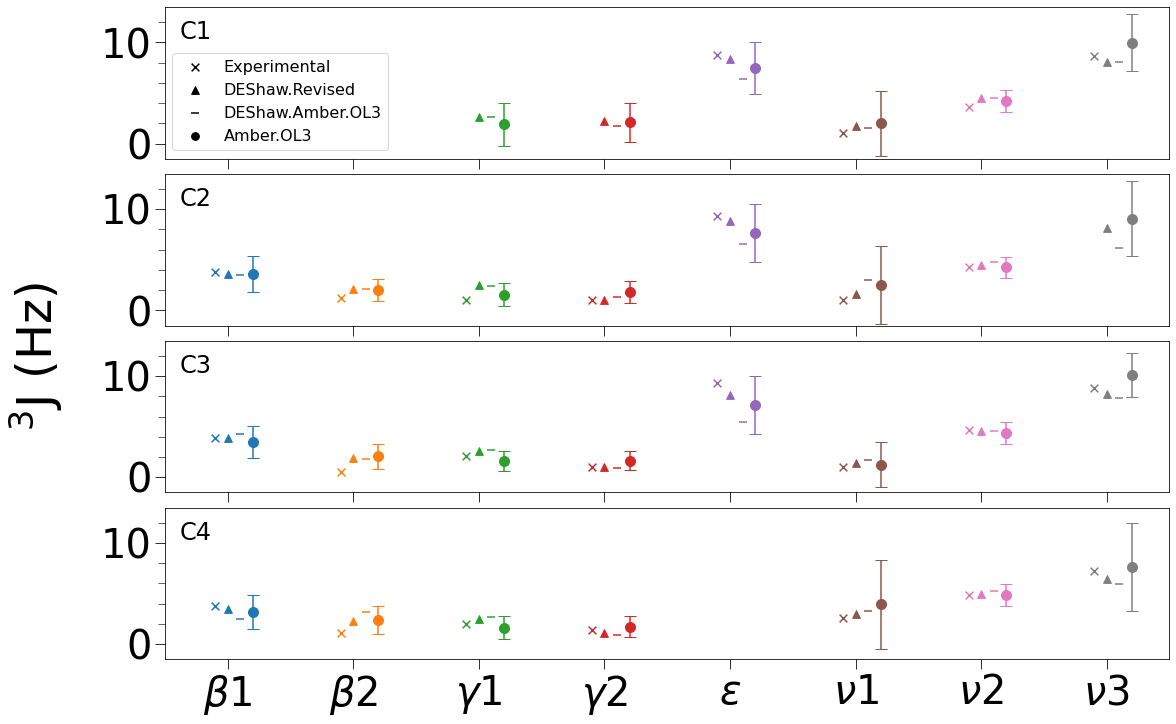

In [332]:
names = ["beta1", "beta2", "gamma1", "gamma2", "epsilon", "nu1", "nu2", "nu3"]

fig, axes = plt.subplots(4,1, figsize=(18, 12), sharex=True)
for i, r in enumerate(res):
    xpos = 0
    
    for name, mycolor in zip(names, mycolors):
        # hide values with zero
        exp_scale, rev_scale, a14_scale, scale = 1, 1, 1, 1
        if df_exp[name][i] == 0:
            exp_scale = 0
        if df_rev[name][i] == 0:
            rev_scale = 0
        if df_a14[name][i] == 0:
            a14_scale = 0
        if df_m[name][i] == 0:
            scale = 0
        
        axes[i].scatter(xpos-0.1, df_exp[name][i], marker='x', s=60 * exp_scale, c=mycolors[mycolor])
        axes[i].scatter(xpos, df_rev[name][i], marker='^', s=60 * rev_scale, c=mycolors[mycolor])
        axes[i].scatter(xpos+0.1, df_a14[name][i], marker='_', s=60 * a14_scale, c=mycolors[mycolor])
        axes[i].errorbar(xpos+0.2, df_m[name][i], yerr=df_s[name][i], fmt='o', capsize=6 * scale, markersize=10 * scale, c=mycolors[mycolor])

            
        # axes
        axes[i].set_title('C{}'.format(i+1), x=0.03, y=0.75, fontsize=24)
        axes[i].yaxis.set_minor_locator(AutoMinorLocator())
        axes[i].yaxis.set_ticks_position("left")
        axes[i].set_ylim(-1.5,13.5)
        axes[i].set_xlim(-0.5,7.5)
        
        # increment position
        xpos += 1

axes[i].set_xticks([0,1,2,3,4,5,6,7], [r"$\beta$1",r"$\beta$2",r"$\gamma$1",r"$\gamma$2",r"$\epsilon$",r"$\nu$1",r"$\nu$2",r"$\nu$3"])        
axes[i].set_ylabel("$^3$J (Hz)")
axes[i].yaxis.set_label_coords(-0.1, 2)

# create scatter and hide marker. this is for legend purpose.
axes[i].scatter(xpos, xpos, marker='x', s=60, c="k", label="Experimental")
axes[i].scatter(xpos, xpos, marker='^', s=60, c="k", label="DEShaw.Revised")
axes[i].scatter(xpos, xpos, marker='_', s=60, c="k", label="DEShaw.Amber.OL3")
axes[i].scatter(xpos, xpos, marker='o', s=60, c="k", label="Amber.OL3")
axes[i].legend(bbox_to_anchor=(0.23, 4.05), fontsize=16)

plt.subplots_adjust(hspace=0.1, wspace=0.1)
#plt.show()
plt.savefig("jcoupling.png")

# J-Coupling (Bayesian inference)fontsize

In [ ]:
#Import required packages
import pymc3 as pm
import arviz as az

In [ ]:
couplings[:,0,-1].shape

In [ ]:
#tosses = [ 0,0,0,0,0,0,0,0,0,1]

#couplings: (frame idx, residue, jcoupling values)
tosses = couplings[:,3,0]
tosses

In [ ]:
df_m["nu1"][3]

In [ ]:
with pm.Model() as model:
    # lets define the prior
    #hypo = pm.Beta('hypo', 2, 2)
    #hypo = pm.Normal('hypo', mu=df_m["nu1"][3], sigma=df_s["nu1"][3])
    hypo = pm.Gamma('hypo', mu=df_m["nu1"][3], sigma=df_s["nu1"][3])
    
    # define probability
    #data = pm.Bernoulli('data', hypo, observed=tosses)
    #data = pm.Normal('data', hypo, observed=tosses)
    data = pm.Poisson('data', hypo, observed=tosses)
    
    # sample
    trace = pm.sample(return_inferencedata=True)

In [ ]:
data

In [ ]:
trace

In [ ]:
# visualize
az.plot_posterior(trace, hdi_prob=0.95)